<a href="https://colab.research.google.com/github/maishamehzabin/CSE475_Lab/blob/main/Lab1_(2022_2_60_108).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data


--2026-01-28 14:49:53--  https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘agaricus-lepiota.data’

agaricus-lepiota.da     [  <=>               ] 364.95K  1.38MB/s    in 0.3s    

2026-01-28 14:49:54 (1.38 MB/s) - ‘agaricus-lepiota.data’ saved [373704]



In [3]:
columns = [
    "class","cap-shape","cap-surface","cap-color","bruises","odor",
    "gill-attachment","gill-spacing","gill-size","gill-color",
    "stalk-shape","stalk-root","stalk-surface-above-ring",
    "stalk-surface-below-ring","stalk-color-above-ring",
    "stalk-color-below-ring","veil-type","veil-color","ring-number",
    "ring-type","spore-print-color","population","habitat"
]

df = pd.read_csv("agaricus-lepiota.data", header=None, names=columns)
df.head()


,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [4]:
print("Dataset shape:", df.shape)
print(df["class"].value_counts())


Dataset shape: (8124, 23)
class
e    4208
p    3916
Name: count, dtype: int64


In [5]:
def encode_dataframe(df):
    encoded_df = df.copy()
    mappings = {}

    for col in df.columns:
        unique_vals = df[col].unique()
        mapping = {val: idx for idx, val in enumerate(unique_vals)}
        mappings[col] = mapping
        encoded_df[col] = df[col].map(mapping)

    return encoded_df, mappings

df_encoded, encoders = encode_dataframe(df)
df_encoded.head()


,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,1,0,1,0,0,1,0,...,0,0,0,0,0,0,0,1,1,1
2,1,1,0,2,0,2,0,0,1,1,...,0,0,0,0,0,0,0,1,1,2
3,0,0,1,2,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,3,1,3,0,1,1,0,...,0,0,0,0,0,0,1,1,2,1


In [6]:
def train_test_split_manual(df, test_size=0.2):
    shuffled = df.sample(frac=1, random_state=42)
    split = int(len(df) * (1 - test_size))
    return shuffled[:split], shuffled[split:]

train_df, test_df = train_test_split_manual(df_encoded)


In [7]:
def entropy(y):
    values, counts = np.unique(y, return_counts=True)
    probs = counts / counts.sum()
    return -np.sum(probs * np.log2(probs))


In [8]:
def information_gain(data, feature, target):
    total_entropy = entropy(data[target])
    values, counts = np.unique(data[feature], return_counts=True)

    weighted_entropy = 0
    for v, c in zip(values, counts):
        subset = data[data[feature] == v]
        weighted_entropy += (c / len(data)) * entropy(subset[target])

    return total_entropy - weighted_entropy


In [9]:
def build_tree(data, features, target):
    if len(np.unique(data[target])) == 1:
        return np.unique(data[target])[0]

    if len(features) == 0:
        return data[target].mode()[0]

    gains = [information_gain(data, f, target) for f in features]
    best_feature = features[np.argmax(gains)]

    tree = {best_feature: {}}
    for val in np.unique(data[best_feature]):
        subset = data[data[best_feature] == val]
        subtree = build_tree(
            subset,
            [f for f in features if f != best_feature],
            target
        )
        tree[best_feature][val] = subtree

    return tree


In [10]:
def predict(tree, sample):
    if not isinstance(tree, dict):
        return tree

    feature = list(tree.keys())[0]
    value = sample[feature]

    if value in tree[feature]:
        return predict(tree[feature][value], sample)
    else:
        return 0


In [11]:
features = list(train_df.columns)
features.remove("class")

dt_tree = build_tree(train_df, features, "class")

dt_preds = test_df.apply(lambda row: predict(dt_tree, row), axis=1)
dt_accuracy = np.mean(dt_preds == test_df["class"])

dt_accuracy


np.float64(1.0)

In [12]:
def bootstrap_sample(data):
    return data.sample(n=len(data), replace=True)


In [13]:
def train_random_forest(train_df, n_trees):
    forest = []
    features = list(train_df.columns)
    features.remove("class")

    for _ in range(n_trees):
        sample = bootstrap_sample(train_df)
        tree = build_tree(sample, features, "class")
        forest.append(tree)

    return forest


In [14]:
def rf_predict(forest, sample):
    predictions = [predict(tree, sample) for tree in forest]
    return max(set(predictions), key=predictions.count)


In [15]:
n_estimators_list = [1, 50, 100, 150, 200, 250]
rf_accuracies = []

for n in n_estimators_list:
    forest = train_random_forest(train_df, n)
    preds = test_df.apply(lambda row: rf_predict(forest, row), axis=1)
    acc = np.mean(preds == test_df["class"])
    rf_accuracies.append(acc)
    print(f"Trees: {n}, Accuracy: {acc:.4f}")


Trees: 1, Accuracy: 1.0000
Trees: 50, Accuracy: 1.0000
Trees: 100, Accuracy: 1.0000
Trees: 150, Accuracy: 1.0000
Trees: 200, Accuracy: 1.0000
Trees: 250, Accuracy: 1.0000


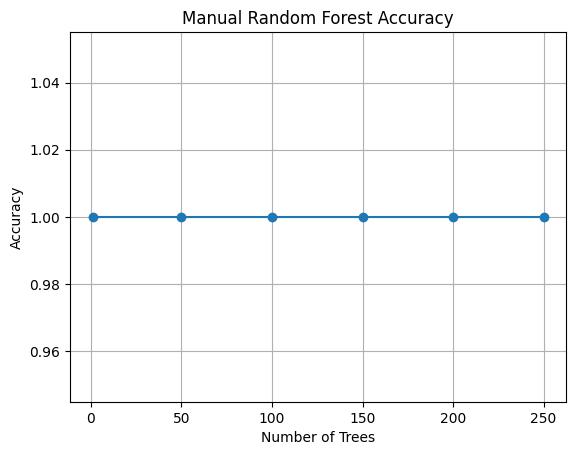

In [ ]:
plt.plot(n_estimators_list, rf_accuracies, marker='o')
plt.xlabel("Number of Trees")
plt.ylabel("Accuracy")
plt.title("Manual Random Forest Accuracy")
plt.grid()
plt.show()


In [ ]:
print("Decision Tree Accuracy:", dt_accuracy)
print("Best Random Forest Accuracy:", max(rf_accuracies))


Decision Tree Accuracy: 1.0
Best Random Forest Accuracy: 1.0


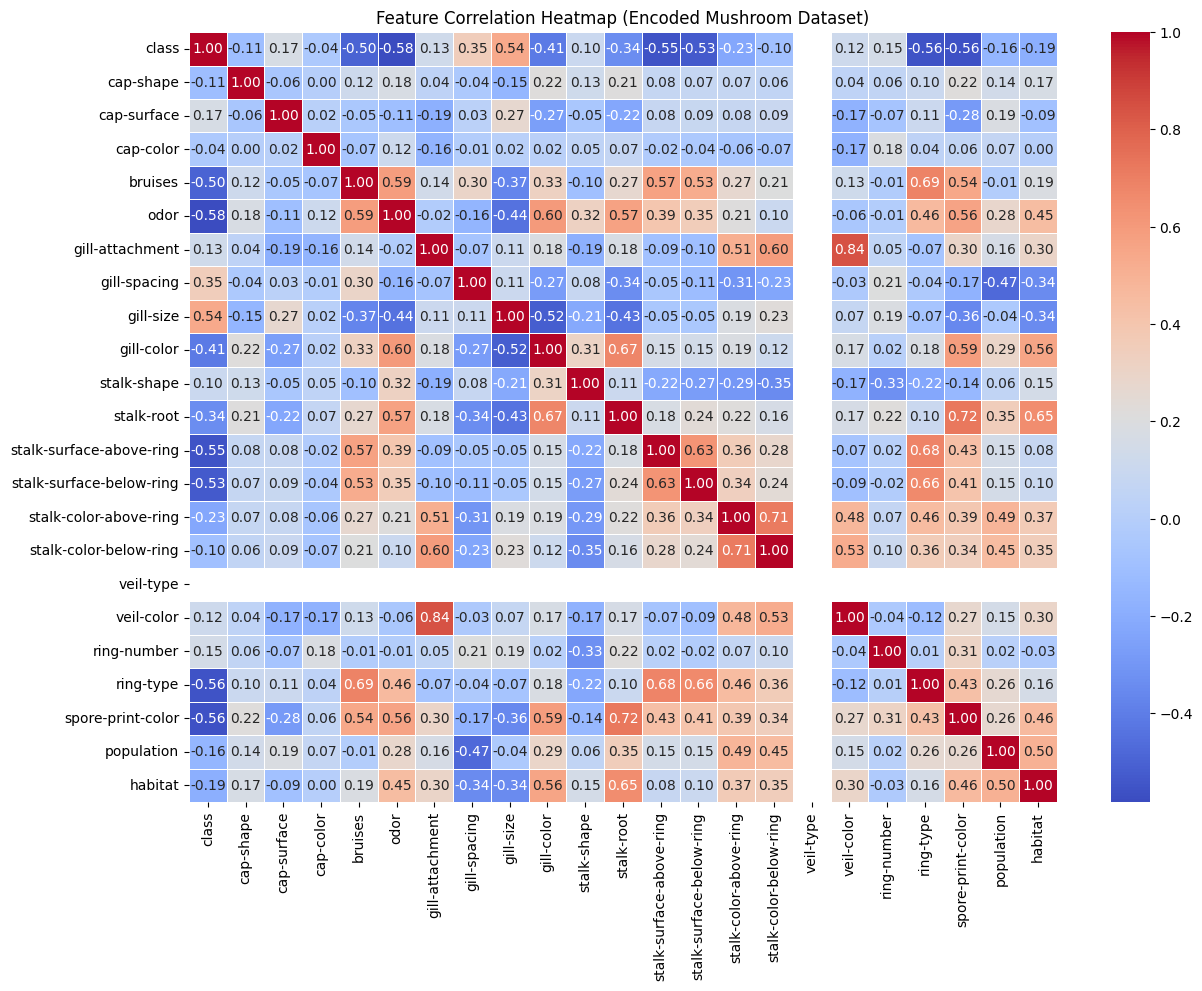

In [ ]:
import seaborn as sns

plt.figure(figsize=(14, 10))

correlation_matrix = df_encoded.corr()

sns.heatmap(
    correlation_matrix,
    cmap="coolwarm",
    annot=True,
    fmt=".2f",
    linewidths=0.5,
    cbar=True
)

plt.title("Feature Correlation Heatmap (Encoded Mushroom Dataset)")
plt.show()
